## Imports

In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Add parent directory to path for imports
sys.path.insert(0, '/srv/scratch/z5370003/projects/src/04_groundwater/variable_density')

from src.data.transform import Normalize
from src.data.patch_dataset_multi_col import GWPatchDatasetMultiCol
from src.data.batch_sampler import PatchBatchSampler
from src.models.neuralop.gino import GINO
from src.models.neuralop.losses import LpLoss, H1Loss

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Configuration

Using the same configuration as the training run

In [2]:
# Create configuration object
class Config:
    def __init__(self):
        # Data directories
        self.base_data_dir = '/srv/scratch/z5370003/projects/data/groundwater/FEFLOW/coastal/variable_density/'
        self.raw_data_subdir = 'all'
        self.patch_data_subdir = 'filter_patch'
        self.raw_data_dir = os.path.join(self.base_data_dir, self.raw_data_subdir)
        self.patch_data_dir = os.path.join(self.base_data_dir, self.patch_data_subdir)
        
        # Target columns
        self.target_cols = ['mass_concentration', 'head']
        self.target_col_indices = [0, 1]
        self.n_target_cols = 2
        
        # Window sizes
        self.input_window_size = 5
        self.output_window_size = 1
        
        # Training parameters
        self.batch_size = 512
        self.shuffle_within_batches = True
        self.shuffle_patches = True
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.seed = 42
        
        # Loss parameters
        self.lambda_conc_focus = 0.5
        self.var_aware_alpha = 0.3
        self.var_aware_beta = 2.0
        
        # Model parameters
        self.coord_dim = 3
        self.gno_radius = 0.15
        self.in_gno_out_channels = 10  # input_window_size * n_target_cols = 5 * 2
        self.in_gno_channel_mlp_layers = [32, 64, 32]
        self.fno_n_layers = 4
        self.fno_n_modes = (12, 12, 8)
        self.fno_hidden_channels = 64
        self.lifting_channels = 64
        self.out_gno_channel_mlp_layers = [32, 64, 32]
        self.projection_channel_ratio = 2
        self.out_channels = 2  # output_window_size * n_target_cols = 1 * 2
        self.latent_query_dims = (32, 32, 24)

args = Config()
print(f"Device: {args.device}")
print(f"Target columns: {args.target_cols}")
print(f"Input window: {args.input_window_size}, Output window: {args.output_window_size}")

Device: cuda
Target columns: ['mass_concentration', 'head']
Input window: 5, Output window: 1


## Data Transforms

Calculate normalization statistics for coordinates and observations

In [3]:
# Calculate coordinate transform
df = pd.read_csv(os.path.join(args.raw_data_dir, '0000.csv'))
coord_mean = df[['X', 'Y', 'Z']].mean().values
coord_std = df[['X', 'Y', 'Z']].std().values
coord_transform = Normalize(mean=coord_mean, std=coord_std)

print(f"Coordinate mean: {coord_mean}")
print(f"Coordinate std: {coord_std}")

# Calculate observation transform
obs_cols = ['mass_concentration', 'head', 'pressure']
obs_mean = df[obs_cols].mean().values
obs_std = df[obs_cols].std().values
obs_transform = Normalize(mean=obs_mean, std=obs_std)

print(f"\nObservation mean: {obs_mean}")
print(f"Observation std: {obs_std}")

del df

Coordinate mean: [ 3.57225665e+05  6.45774324e+06 -9.27782248e+00]
Coordinate std: [569.1699999  566.35797379  15.26565618]

Observation mean: [1.77942252e+04 3.95881156e-01 9.48469883e+01]
Observation std: [1.55859465e+04 2.13080032e-01 1.51226320e+02]


## Load Dataset

Create training dataset with the configured transforms

In [4]:
# Create training dataset
train_ds = GWPatchDatasetMultiCol(
    data_path=args.patch_data_dir,
    dataset='train',
    coord_transform=coord_transform,
    obs_transform=obs_transform,
    input_window_size=args.input_window_size,
    output_window_size=args.output_window_size,
    target_col_indices=args.target_col_indices,
)

print(f"Training dataset size: {len(train_ds)} sequences")

# Get unique patch IDs
patch_ids = train_ds.get_all_patch_ids()
unique_patches = len(np.unique(patch_ids))
print(f"Number of patches: {unique_patches}")

Computed variance-aware weights for 20 patches
Dataset variance range: [0.000000, 405223819.275790]
Dataset mean variance: 3213522.908705
Training dataset size: 13260 sequences
Building patch_ids cache...
Cached 13260 patch_ids
Number of patches: 20


In [5]:
core_coords = []
weights = []

for patch_data in train_ds.weighted_patch_data:
    core_coords.append(patch_data['core_coords'])
    weights.append(patch_data['weights'])


core_coords = np.concatenate(core_coords)
weights = np.concatenate(weights)

# filter_idx = weights > np.percentile(weights, 50)
# core_coords = core_coords[filter_idx]
# weights = weights[filter_idx]

weights.shape, core_coords.shape

((10227,), (10227, 3))

In [6]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# --- 2. Create the Plot ---
fig = go.Figure(data=[go.Scatter3d(
    # Slicing the (N, 3) array into X, Y, Z components
    x=core_coords[:, 0],
    y=core_coords[:, 1],
    z=core_coords[:, 2],
    mode='markers',
    # 1. Pass the weights array to customdata
    customdata=weights,
    
    # 2. Define the hover template
    # %{customdata} refers to the data passed above. 
    # :.4f formats it to 4 decimal places.
    # <extra></extra> hides the secondary box that usually shows the trace name.
    hovertemplate=(
        '<b>Weight:</b> %{customdata:.4f}<br>' +
        'X: %{x:.2f}<br>' +
        'Y: %{y:.2f}<br>' +
        'Z: %{z:.2f}' +
        '<extra></extra>'
    ),
    marker=dict(
        size=3,                # Adjust dot size (smaller is better for large datasets)
        color=weights,         # Map color to your weights array
        colorscale='Viridis',  # Options: 'Viridis', 'Plasma', 'Inferno', 'Jet', etc.
        opacity=0.8,           # Transparency helps visualize depth in 3D
        colorbar=dict(title='Weight Magnitude')
    )
)])

# --- 3. Update Layout for Better Visualization ---
fig.update_layout(
    title='3D Scatter Plot of Core Coordinates',
    margin=dict(l=0, r=0, b=0, t=40), # Tight layout
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

fig.show()

In [7]:
np.percentile(weights, 99)

1.0250746011734009

## Create DataLoader with Collate Function

Set up the batch sampler and collate function to create batches from the same patch

In [5]:
def create_collate_fn(args):
    """Create collate function that batches samples from the same patch."""
    def collate_fn(batch_samples):
        """Collate function that combines samples into a batch.
        
        Args:
            batch_samples: List of sample dictionaries from the same patch
            
        Returns:
            dict: Batch dictionary with combined point cloud and sequences
        """
        # All samples in the batch come from the same patch (by sampler design)
        core_coords = batch_samples[0]['core_coords']
        ghost_coords = batch_samples[0]['ghost_coords']

        # Single point cloud per batch: [N_core+N_ghost, 3]
        # Concatenate core and ghost points to form complete spatial domain
        point_coords = torch.concat([core_coords, ghost_coords], dim=0).float().to(args.device)

        # Create latent queries grid over the per-batch bounding box
        # This provides a regular grid for the FNO component
        coords_min = torch.min(point_coords, dim=0).values
        coords_max = torch.max(point_coords, dim=0).values
        latent_query_arr = [
            torch.linspace(coords_min[i], coords_max[i], args.latent_query_dims[i], device=args.device)
            for i in range(args.coord_dim)
        ]
        # Create meshgrid and stack to get [Qx, Qy, Qz, 3] tensor
        latent_queries = torch.stack(torch.meshgrid(*latent_query_arr, indexing='ij'), dim=-1)

        # Build batched sequences: concat along points (dim=0), batch along dim=0
        x_list, y_list = [], []
        for sample in batch_samples:
            # Combine core and ghost inputs/outputs for each sample
            # Note: sequences are already concatenated across target columns in the dataset
            sample_input = torch.concat([sample['core_in'], sample['ghost_in']], dim=0).float().unsqueeze(0)
            sample_output = torch.concat([sample['core_out'], sample['ghost_out']], dim=0).float().unsqueeze(0)
            x_list.append(sample_input)
            y_list.append(sample_output)

        # Stack all sequences into batch tensors and move to device
        x = torch.cat(x_list, dim=0).to(args.device)  # [B, N_points, input_window_size * n_target_cols]
        y = torch.cat(y_list, dim=0).to(args.device)  # [B, N_points, output_window_size * n_target_cols]

        # Return batch dictionary
        batch = {
            'point_coords': point_coords,      # [N_points, 3] - already on device
            'latent_queries': latent_queries,  # [Qx, Qy, Qz, 3] - already on device
            'x': x,                           # [B, N_points, input_window_size * n_target_cols] - moved to device
            'y': y,                           # [B, N_points, output_window_size * n_target_cols] - moved to device
            'core_len': len(core_coords),     # Number of core points (for loss masking)
            'patch_id': batch_samples[0]['patch_id'],  # For reference
            'weights': batch_samples[0]['weights']
        }
        return batch
    return collate_fn

# Create batch sampler and data loader
batch_sampler = PatchBatchSampler(
    dataset=train_ds,
    batch_size=args.batch_size,
    shuffle_within_batches=args.shuffle_within_batches,
    shuffle_patches=args.shuffle_patches,
)

train_loader = DataLoader(
    train_ds,
    batch_sampler=batch_sampler,
    collate_fn=create_collate_fn(args),
    num_workers=0,
)

print(f"DataLoader created with {len(train_loader)} batches")

Building patch groups (one-time operation)...
Found 20 patches with 13260 total samples
Patch sizes: min=663, max=663, avg=663.0
Pre-built 40 batches
DataLoader created with 40 batches


## Initialize Model

Create the GINO model with the configured parameters

In [6]:
model = GINO(
    # Input GNO configuration
    in_gno_coord_dim=args.coord_dim,
    in_gno_radius=args.gno_radius,
    in_gno_out_channels=args.in_gno_out_channels,
    in_gno_channel_mlp_layers=args.in_gno_channel_mlp_layers,
    
    # FNO configuration
    fno_n_layers=args.fno_n_layers,
    fno_n_modes=args.fno_n_modes,
    fno_hidden_channels=args.fno_hidden_channels,
    lifting_channels=args.lifting_channels,
    
    # Output GNO configuration
    out_gno_coord_dim=args.coord_dim,
    out_gno_radius=args.gno_radius,
    out_gno_channel_mlp_layers=args.out_gno_channel_mlp_layers,
    projection_channel_ratio=args.projection_channel_ratio,
    out_channels=args.out_channels,
    
    # Neighbor search settings
    use_open3d_neighbor_search=True,
).to(args.device)

print(f"Model initialized on {args.device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model initialized on cuda
Total parameters: 23,658,508


## Get a Batch

Extract one batch from the training data for testing

In [7]:
# Get first batch
batch_iter = iter(train_loader)

In [8]:
batch = next(batch_iter)

print("Batch contents:")
print(f"  point_coords shape: {batch['point_coords'].shape}")
print(f"  latent_queries shape: {batch['latent_queries'].shape}")
print(f"  x (inputs) shape: {batch['x'].shape}")
print(f"  y (targets) shape: {batch['y'].shape}")
print(f"  core_len (core points): {batch['core_len']}")
print(f"  patch_id: {batch['patch_id']}")
print(f"  weights shape: {batch['weights'].shape}")

Batch contents:
  point_coords shape: torch.Size([589, 3])
  latent_queries shape: torch.Size([32, 32, 24, 3])
  x (inputs) shape: torch.Size([151, 589, 10])
  y (targets) shape: torch.Size([151, 589, 2])
  core_len (core points): 504
  patch_id: 19
  weights shape: (504,)


## Variance-Aware Loss Function

Define the variance-aware multi-column loss function

In [9]:
def variance_aware_multicol_loss(
    y_pred,
    y_true,
    output_window_size,
    target_cols,
    lambda_conc_focus=0.5,
    alpha=0.3,
    beta=2.0,
):
    """
    y_pred, y_true: [B, N_points, T_out * C]
    output_window_size: T_out
    target_cols: list like ['mass_concentration', 'head']
    lambda_conc_focus: how much extra weight to put on variance-aware conc loss
    alpha: base weight for low-variance nodes (0<alpha<1)
    beta: exponent controlling how sharply we emphasise high-variance nodes
    """

    B, N, TC = y_pred.shape
    C = TC // output_window_size
    assert TC == output_window_size * C

    # reshape to [B, N, T_out, C]
    y_pred = y_pred.view(B, N, output_window_size, C)
    y_true = y_true.view(B, N, output_window_size, C)

    # Loss function
    global_loss_fn = LpLoss(d=2, p=2, reduce_dims=[0, 1], reductions='mean')
    local_loss_fn = LpLoss(d=1, p=2, reductions='mean')

    # ----- 1) global MSE over all variables -----
    global_loss = global_loss_fn(y_pred, y_true)

    # ----- 2) variance-aware term for concentration -----
    conc_idx = target_cols.index('mass_concentration')  # assumes name present

    conc_pred = y_pred[..., conc_idx]   # [B, N, T]
    conc_true = y_true[..., conc_idx]   # [B, N, T]

    # node-wise temporal variance (on *normalized* targets)
    with torch.no_grad():
        # var over time dimension
        var_t = conc_true.var(dim=[0, 2], unbiased=False)  # [N]
        
        # normalise variance within the batch
        # (avoid division by tiny mean)
        var_norm = var_t / (var_t.mean() + 1e-6)

        # map to weights in [alpha, ~1] with emphasis on high variance
        #   w = alpha + (1-alpha) * var_norm^beta, then renormalise mean to 1
        weights = alpha + (1.0 - alpha) * (var_norm ** beta)
        weights = weights / (weights.mean() + 1e-6)   # keep gradients stable
        

    conc_l2 = local_loss_fn(conc_pred, conc_true)        # [N]
    conc_var_loss = (weights * conc_l2).mean()

    # ----- 3) combine -----
    loss = (1.0 - lambda_conc_focus) * global_loss + lambda_conc_focus * conc_var_loss

    return {'loss_total': loss, 
            'loss_global': global_loss.detach(),
            'loss_conc_var': conc_var_loss.detach()}, var_t, weights

## Test Forward Pass and Loss Computation

Run a forward pass and compute the loss on the batch

In [10]:
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    # Forward pass
    outputs = model(
        input_geom=batch['point_coords'],
        latent_queries=batch['latent_queries'],
        x=batch['x'],
        output_queries=batch['point_coords'],
    )
    
    print(f"\nModel output shape: {outputs.shape}")
    print(f"Expected shape: [batch_size={args.batch_size}, n_points={batch['point_coords'].shape[0]}, out_channels={args.out_channels}]")
    
    # Extract core points for loss computation (first core_len points are core points)
    core_len = batch['core_len']
    y_pred_core = outputs[:, :core_len, :]  # [B, N_core, out_channels]
    y_true_core = batch['y'][:, :core_len, :]  # [B, N_core, out_channels]
    
    print(f"\nCore predictions shape: {y_pred_core.shape}")
    print(f"Core targets shape: {y_true_core.shape}")
    print(f"Number of core points: {core_len}")
    
    # Compute loss
    loss_dict, var_t, weights = variance_aware_multicol_loss(
        y_pred_core,
        y_true_core,
        output_window_size=args.output_window_size,
        target_cols=args.target_cols,
        lambda_conc_focus=args.lambda_conc_focus,
        alpha=args.var_aware_alpha,
        beta=args.var_aware_beta,
    )
    
    print("\n" + "="*60)
    print("Loss Components:")
    print("="*60)
    print(f"Total Loss:        {loss_dict['loss_total'].item():.6f}")
    print(f"Global Loss:       {loss_dict['loss_global'].item():.6f}")
    print(f"Conc Variance Loss: {loss_dict['loss_conc_var'].item():.6f}")
    print("="*60)


Model output shape: torch.Size([151, 589, 2])
Expected shape: [batch_size=512, n_points=589, out_channels=2]

Core predictions shape: torch.Size([151, 504, 2])
Core targets shape: torch.Size([151, 504, 2])
Number of core points: 504

Loss Components:
Total Loss:        0.776677
Global Loss:       0.797434
Conc Variance Loss: 0.755919


In [11]:
import matplotlib.pyplot as plt

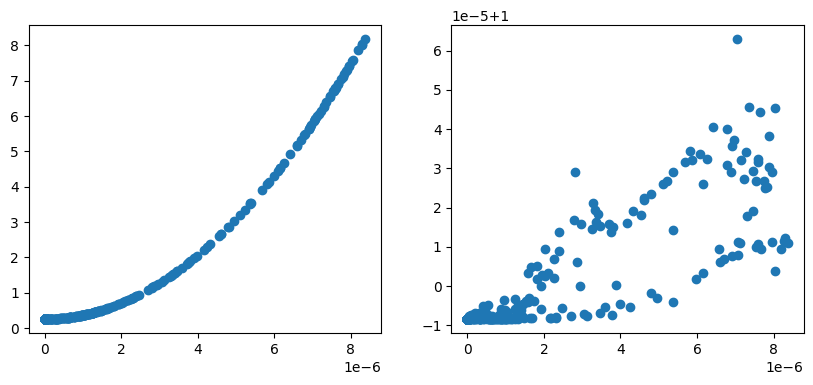

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(var_t.cpu().numpy(), weights.cpu().numpy())
ax[1].scatter(var_t.cpu().numpy(), batch['weights'])

# ax.hist(weights.cpu().numpy(), bins=100)

## Analyze Loss Components

Examine how the loss is distributed across variables and timesteps

In [ ]:
with torch.no_grad():
    # Reshape predictions and targets
    B, N, D = y_pred_core.shape
    n_cols = len(args.target_cols)
    
    y_pred_reshaped = y_pred_core.reshape(B, N, args.output_window_size, n_cols)
    y_true_reshaped = y_true_core.reshape(B, N, args.output_window_size, n_cols)
    
    # Compute MSE per column
    mse_per_col = ((y_pred_reshaped - y_true_reshaped) ** 2).mean(dim=(0, 1, 2))  # [n_cols]
    
    print("\nMSE per target column:")
    for i, col_name in enumerate(args.target_cols):
        print(f"  {col_name}: {mse_per_col[i].item():.6f}")
    
    # Analyze concentration variance if available
    conc_idx = None
    for idx, col in enumerate(args.target_cols):
        if 'mass_concentration' in col or 'concentration' in col:
            conc_idx = idx
            break
    
    if conc_idx is not None:
        conc_true = y_true_reshaped[:, :, :, conc_idx]  # [B, N, T]
        spatial_var = conc_true.var(dim=1, unbiased=False)  # [B, T]
        
        print(f"\nConcentration spatial variance per timestep:")
        for t in range(args.output_window_size):
            avg_var = spatial_var[:, t].mean().item()
            print(f"  Timestep {t}: {avg_var:.6f}")
        
        # Compute weights
        eps = 1e-6
        weight = 1.0 / (args.var_aware_alpha * spatial_var + eps) ** args.var_aware_beta
        weight_normalized = weight / weight.sum(dim=1, keepdim=True)
        
        print(f"\nNormalized variance-aware weights per timestep:")
        for t in range(args.output_window_size):
            avg_weight = weight_normalized[:, t].mean().item()
            print(f"  Timestep {t}: {avg_weight:.6f}")

## Visualize Predictions vs Targets

Plot predictions and targets for the first sample in the batch

In [ ]:
# Select first sample
sample_idx = 0

with torch.no_grad():
    y_pred_sample = y_pred_core[sample_idx].cpu().numpy()  # [N_core, out_channels]
    y_true_sample = y_true_core[sample_idx].cpu().numpy()  # [N_core, out_channels]
    
    # Reshape to separate columns
    y_pred_sample = y_pred_sample.reshape(-1, args.output_window_size, n_cols)
    y_true_sample = y_true_sample.reshape(-1, args.output_window_size, n_cols)
    
    # Create subplots for each column
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))
    if n_cols == 1:
        axes = [axes]
    
    for col_idx, col_name in enumerate(args.target_cols):
        ax = axes[col_idx]
        
        # Get values for this column (first timestep)
        pred_vals = y_pred_sample[:, 0, col_idx]
        true_vals = y_true_sample[:, 0, col_idx]
        
        # Scatter plot: predictions vs targets
        ax.scatter(true_vals, pred_vals, alpha=0.5, s=1)
        
        # Add diagonal line (perfect prediction)
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
        
        ax.set_xlabel('True values')
        ax.set_ylabel('Predicted values')
        ax.set_title(f'{col_name}\n(Sample {sample_idx}, Timestep 0)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nPrediction Statistics (Sample 0, Timestep 0):")
    for col_idx, col_name in enumerate(args.target_cols):
        pred_vals = y_pred_sample[:, 0, col_idx]
        true_vals = y_true_sample[:, 0, col_idx]
        
        mse = np.mean((pred_vals - true_vals) ** 2)
        mae = np.mean(np.abs(pred_vals - true_vals))
        
        print(f"\n{col_name}:")
        print(f"  True range: [{true_vals.min():.4f}, {true_vals.max():.4f}]")
        print(f"  Pred range: [{pred_vals.min():.4f}, {pred_vals.max():.4f}]")
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")

## Summary

This notebook provides:
1. Model initialization with the exact training configuration
2. A batch of data ready for testing
3. Forward pass computation
4. Variance-aware loss computation with component breakdown
5. Analysis tools to examine how the loss affects different variables and timesteps

You can now experiment with different loss parameters:
- `lambda_conc_focus`: Balance between global and variance-aware loss (0-1)
- `var_aware_alpha`: Scaling factor for variance weighting
- `var_aware_beta`: Exponent for variance weighting (higher = more aggressive weighting)